# Economic Clustering with FRED-MD and Russell 2000 data

In macro and equity research we're often interested in macroeconomic regimes and their effects on asset performance. In this project we use the FRED-MD data combined with Russell 2000 returns to use a well known clustering algorithm to mine for patterns across time.

## 1. Getting FRED-MD Data

In [1]:
# Importing required libraries

import pandas as pd # working with dataframe
import yfinance as yf # getting Russell 2000 price data
from sklearn.cluster import KMeans # to implement our KMeans Algorithm
from sklearn.preprocessing import StandardScaler # to scale our data for KMeans
import matplotlib.pyplot as plt # for plotting our clustering
from datetime import datetime # to work with dates

In [3]:

## setting this separately so we can change this variable each month, format yyyy-mm
year_month = '2024-05'

fred_url = f'https://files.stlouisfed.org/files/htdocs/fred-md/monthly/{year_month}.csv'
fred_md_df = pd.read_csv(fred_url)

# Remove the second row which contains transformation information
fred_md_df = fred_md_df.drop(index=0)

# Strip any leading/trailing whitespace from column names
fred_md_df.columns = fred_md_df.columns.str.strip()

# Rename 'sasdate' to 'Date' and parse it as dates
fred_md_df.rename(columns={'sasdate': 'Date'}, inplace=True)
fred_md_df['Date'] = pd.to_datetime(fred_md_df['Date'])

# Set the dates to end of month
fred_md_df['Date'] = fred_md_df['Date'] + pd.offsets.MonthEnd(0)

# Let's inspect our dataframe
fred_md_df.head()


,Date,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
1,1959-01-31,2583.560,2426.0,15.188,276676.8154,18235.77392,21.9665,23.3891,22.2688,31.7011,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
2,1959-02-28,2593.596,2434.8,15.346,278713.9773,18369.56308,22.3966,23.7048,22.4617,31.9337,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
3,1959-03-31,2610.396,2452.7,15.491,277775.2539,18523.05762,22.7193,23.8483,22.5719,31.9337,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
4,1959-04-30,2627.446,2470.0,15.435,283362.7075,18534.46600,23.2032,24.1927,22.9026,32.4374,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN
5,1959-05-31,2642.720,2486.4,15.622,285307.2201,18679.66354,23.5528,24.3936,23.1231,32.5925,...,18.280,10.238,2.17,2.48,2.08,95.3,6753.0,12646.0,80.7315,NaN


## 2. Creating a Subset of Indicators
We create a subset of the FRED MD data from the original and set the dates to be end of month for to allow us to perform the join later

In [4]:

# Step 3: Select important columns and rename them
important_columns = ['Date', 'INDPRO', 'UNRATE', 'CPIAUCSL', 'FEDFUNDS']
renamed_columns = {
    'INDPRO': 'Industrial_Production',
    'UNRATE': 'Unemployment_Rate',
    'CPIAUCSL': 'Consumer_Price_Index',
    'FEDFUNDS': 'Federal_Funds_Rate'
}

fred_md_subset = fred_md_df[important_columns].rename(columns=renamed_columns)

# Step 4: Filter the data for the most recent 5 years
most_recent_date = fred_md_subset['Date'].max()
start_date = most_recent_date - pd.DateOffset(years=5)
fred_md_recent = fred_md_subset[fred_md_subset['Date'] >= start_date]
fred_md_recent.head()

,Date,Industrial_Production,Unemployment_Rate,Consumer_Price_Index,Federal_Funds_Rate
724,2019-04-30,102.2481,3.7,255.233,2.42
725,2019-05-31,102.4192,3.6,255.296,2.39
726,2019-06-30,102.4893,3.6,255.213,2.38
727,2019-07-31,102.0236,3.7,255.802,2.40
728,2019-08-31,102.7754,3.6,256.036,2.13


## 3. Getting Russell 2000 Price Data
Downloading the data from the Yahoo! Finance API and applying a monthly return transformation and joining it on the FRED MD data

In [7]:

# Step 5: Get the Russell 2000 price from the Yahoo Finance API
russell_2000 = yf.download('^RUT', start=start_date, end=most_recent_date)
russell_2000 = russell_2000[['Adj Close']].rename(columns={'Adj Close': 'Russell_2000'})

# Step 6: Resample to end-of-month frequency and calculate rolling monthly returns
russell_2000_monthly = russell_2000.resample('M').last()
russell_2000_monthly.index = russell_2000_monthly.index + pd.offsets.MonthEnd(0)
russell_2000_monthly['Russell_2000_Return'] = russell_2000_monthly['Russell_2000'].pct_change()

# Reset index to merge on date
russell_2000_monthly.reset_index(inplace=True)

# Step 7: Join the Russell 2000 data with the FRED-MD subset
joined_df = pd.merge(fred_md_recent, russell_2000_monthly, left_on='Date', right_on='Date', how='inner')

joined_df = joined_df.dropna()

## We create another dataframe without dates as KMeans will not take dates as an input

joined_df_no_date = joined_df.drop(columns=['Date'])

joined_df.head()


[*********************100%%**********************]  1 of 1 completed


,Russell_2000
Date,
2019-04-30,1591.209961
2019-05-01,1576.380005
2019-05-02,1582.650024
2019-05-03,1614.020020
2019-05-06,1614.979980
...,...
2019-09-13,1578.140015
2019-09-16,1584.599976
2019-09-17,1578.290039


## 4. Applying K-Means
We scale the data using standardization and apply the KMeans Algorithm, K-Means is an unsupervised Machine Learning algorithm that let's us understand the patterns in the dataset. It is commonly used to understand economic regimes.

In [22]:

# Step 8: Run KMeans clustering on the joined data
# Select relevant columns for clustering
clustering_columns = ['Industrial_Production', 'Unemployment_Rate', 'Consumer_Price_Index', 'Federal_Funds_Rate', 'Russell_2000_Return']
clustering_data = joined_df_no_date[clustering_columns].dropna()

# Standardize the data (optional but recommended for clustering)
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

# Apply KMeans clustering adding clusters as a column to joined data set
kmeans = KMeans(n_clusters=3, random_state=42)
joined_df_no_date['Cluster'] = kmeans.fit_predict(clustering_data_scaled)




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## 5. Plotting the Results

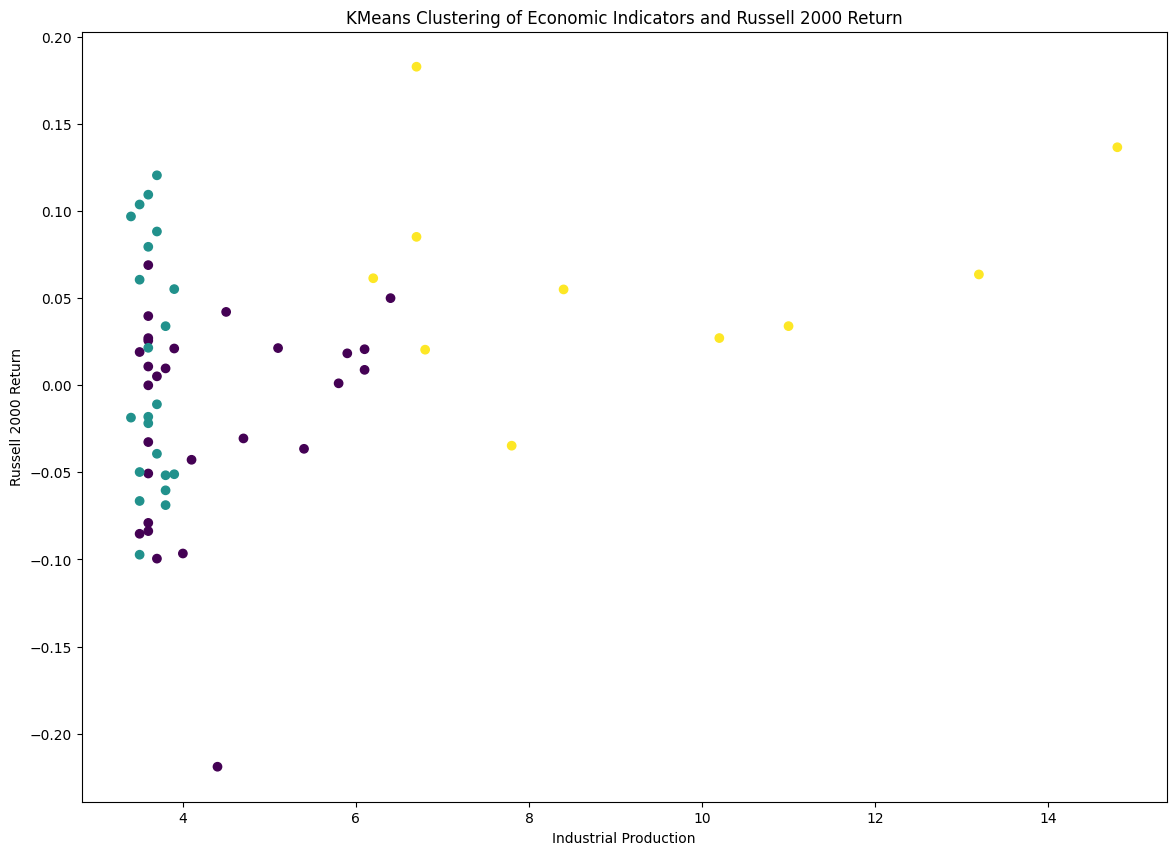

In [27]:
# Plot the resultant clusters with date annotations
plt.figure(figsize=(14, 10))

# Choose two economic variable  on which to visualize clusters

eco_var1 = 'Unemployment_Rate'
eco_var2 = 'Russell_2000_Return'


x_axis = joined_df_no_date[eco_var1]
y_axis = joined_df_no_date[eco_var2]

scatter = plt.scatter(x_axis, y_axis, c=joined_df_no_date['Cluster'], cmap='viridis', label=joined_df_no_date['Cluster'])
plt.xlabel('Industrial Production')
plt.ylabel('Russell 2000 Return')
plt.title('KMeans Clustering of Economic Indicators and Russell 2000 Return')


# Annotate points with dates
for i, row in joined_df.iterrows():
    plt.annotate(row['Date'].strftime('%Y-%m'), (row['Industrial_Production'], row['Russell_2000_Return']),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

plt.show()